In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON
import math 

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

# Getting rid of some outliers
ny = ny[(ny['YearBuilt'] > 1850) & (ny['YearBuilt'] < 2020) & (ny['NumFloors'] != 0)]

C:\Users\asher\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,23,24,25,26,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\asher\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,23,64,65,80) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\asher\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,24,26) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\asher\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,23,64,65,77) have mixed types. Specify dtype option on import or set low_memory=False.

C:\Users\asher\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning:

Columns (19,20,22,24,64,65,80) have mixed types. Specify dtype option on import or set l

I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:
wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['XCoord'] = 0.3048*ny['XCoord']
ny['YCoord'] = 0.3048*ny['YCoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['XCoord'].values, ny['YCoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='anm39@cornell.edu', api_key='18paMp1dQ1Mp9itZ3R7R')

In [5]:

trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('YearBuilt').count()['BBL'].index,
    y = ny.groupby('YearBuilt').count()['BBL']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig, filename = 'ny-year-built', )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~AsherMeyers/0 or inside your plot.ly account where it is named 'ny-year-built'


Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

In [6]:

ny.columns.values

array(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand',
       'AssessTot', 'BBL', 'BldgArea', 'BldgClass', 'BldgDepth',
       'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR',
       'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR', 'CondoNo',
       'Council', 'EDesigNum', 'Easements', 'ExemptLand', 'ExemptTot',
       'Ext', 'FIRM07_FLAG', 'FIRM07_Flag', 'FacilFAR', 'FactryArea',
       'FireComp', 'GarageArea', 'HealthArea', 'HealthCenterDistrict',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'NumBldgs',
       'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1', 'Overlay2',
       'OwnerName', 'OwnerType', 'PFIRM15_FLAG', 'PFIRM15_Flag',
       'PLUTOMapID', 'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR',
       'RetailArea', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistrict', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMa

Binning:

Brittanica [1] states that in the 1880s, in the earlier portion of our dataset, buildings 10-20 stories tall were considered skyscrapers. The Home Insurance Building at 10 stories, built in Chicago in 1885, is a prominent example [2]. One can conclude buildings of such height were the 'apex' of what was possible then. New York's first Waldorf-Astoria was 16 stories tall and built in 1893, then expanded in 1897[3]. The New York World building was 20 stories, and completed in 1890. Therefore, the first bin is 10-20 stories.

The World had the most stories among the tallest buildings in New York, until 1899, when the Park Row building arrived with 30 stories. Therefore the next bin is 21-30 stories.

Then a series of three buildings, 47, 50, and 57 stories, numbering 47, 50 and 57 stories, arrived between 1908 and 1913. The last of these is 233 Broadway, though it's listed at 60.5 stories in our dataset. Consequently, the next bin is 31-61 stories.

In 1930, a 70 story, then a 77 story building each took the tallest in New York record. Consequently this bin is 58-77 stories.

But in 1930, a third record winner appeared, the Empire State Building at 102 stories, unmatched until 1970 with the World Trade Center's 110 stories. Considering how this is so much higher than the previous record, it likely deserves its own bin - 78-102 stories.

#### Removal of Non-Novel Buildings

I removed all buildings in a given category, after that category had existed for 20 years. Two decades is considered enough time to work out the kinks in new building technologies. I made an exception for the first category, 10-20 stories, since some of the buildings in that category appear to have towers, like a church tower, that are, structurally speaking, nothing like a skyscraper of equal height, and thus do not necessarily indicate new structural technology.

Lastly, within our dataset, the two tallest entries are erroneous, and don't correspond to actual skyscrapers (31 Beachview Avenue, 100 Jefferson Street), so those will be removed.


1. https://www.britannica.com/technology/skyscraper
2. https://booksite.elsevier.com/samplechapters/9781856175555/02~Chapter_1.pdf
3. https://en.wikipedia.org/wiki/Waldorf%E2%80%93Astoria_(1893%E2%80%931929)
4. https://en.wikipedia.org/wiki/New_York_World_Building

In [7]:
ny.sort_values(by='NumFloors').tail().loc[:, ["Address", "AssessLand", "AssessTot", "NumFloors", "Borough", "YearBuilt"]]

,Address,AssessLand,AssessTot,NumFloors,Borough,YearBuilt
386503,432 PARK AVENUE,23267256,99849861,90.0,MN,2012
377818,338 5 AVENUE,99000000,396455850,102.0,MN,1931
401948,185 GREENWICH STREET,225000000,1459519424,104.0,MN,2009
800329,31 BEACHVIEW AVENUE,3614,20733,114.0,SI,2003
82018,100 JEFFERSON STREET,4200,28224,119.0,BK,2008


In [8]:
# Start your answer here, inserting more cells as you go along
ny1 = ny[ny["NumFloors"] < 105] # There are erroneous entries with 114 and 119 stories.
ny1["YearBuilt"] = np.floor(ny1["YearBuilt"]/10)*10
ny10s = ny1[(ny1.NumFloors >= 10) & (ny1.NumFloors <= 20) & (ny1.YearBuilt < 1900)]
ny20s = ny1[(ny1.NumFloors >= 21) & (ny1.NumFloors <= 30)& (ny1.YearBuilt < 1920)]
ny30s = ny1[(ny1.NumFloors >= 31) & (ny1.NumFloors <= 61)& (ny1.YearBuilt < 1930)]
ny40s = ny1[(ny1.NumFloors >= 62) & (ny1.NumFloors <= 77) & (ny1.YearBuilt < 1970) & (ny1.YearBuilt > 1910)] 
#140 Franklin Street is listed as being built in 1910 and having 65 stories, but this doesn't match historical records
ny50s = ny1[(ny1.NumFloors >= 78) & (ny1.NumFloors <= 102) & (ny1.YearBuilt < 1970)]
ny60s = ny1[(ny1.NumFloors > 102)]

trace1 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny10s.groupby('YearBuilt').count()['BBL'].index,
    y = ny10s.groupby('YearBuilt').count()['BBL'],
    name = "10-20 Stories",
    #mode = "lines+markers"
)

trace2 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny20s.groupby('YearBuilt').count()['BBL'].index,
    y = ny20s.groupby('YearBuilt').count()['BBL'],
    name = "21-30 Stories",
    #mode = "lines+markers"
)

trace3 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny30s.groupby('YearBuilt').count()['BBL'].index,
    y = ny30s.groupby('YearBuilt').count()['BBL'],
    name = "31-61 Stories",
    #mode = "lines+markers"
)

trace4 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny40s.groupby('YearBuilt').count()['BBL'].index,
    y = ny40s.groupby('YearBuilt').count()['BBL'],
    name = "62-77 Stories",
    #mode = "lines+markers"
)

trace5 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny50s.groupby('YearBuilt').count()['BBL'].index,
    y = ny50s.groupby('YearBuilt').count()['BBL'],
    name = "78-102 Stories",
    #mode = "lines+markers"
)

trace6 = go.Bar(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny60s.groupby('YearBuilt').count()['BBL'].index,
    y = ny60s.groupby('YearBuilt').count()['BBL'],
    name = "103+ Stories",
    #mode = "lines+markers"
)

layout = go.Layout(
    xaxis = dict(title = 'Number of Buildings Built by Height and Decade'),
    yaxis = dict(title = 'Number of Lots Built, (Logscale)', type = 'log', autorange = "True")
)

fig = go.Figure(data = [trace1, trace2, trace3, trace4, trace5, trace6],
                layout = layout)

py.iplot(fig, filename = 'ny-year-built', )

C:\Users\asher\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~AsherMeyers/0 or inside your plot.ly account where it is named 'ny-year-built'


## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [26]:
yearbins = 16
floorbins = 100

yearBuiltCut = pd.cut(ny['YearBuilt'], np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['NumFloors'], np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['YearBuilt'].min(), ny['YearBuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['NumFloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['BBL'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data, filename = 'datashader-2d-hist')

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



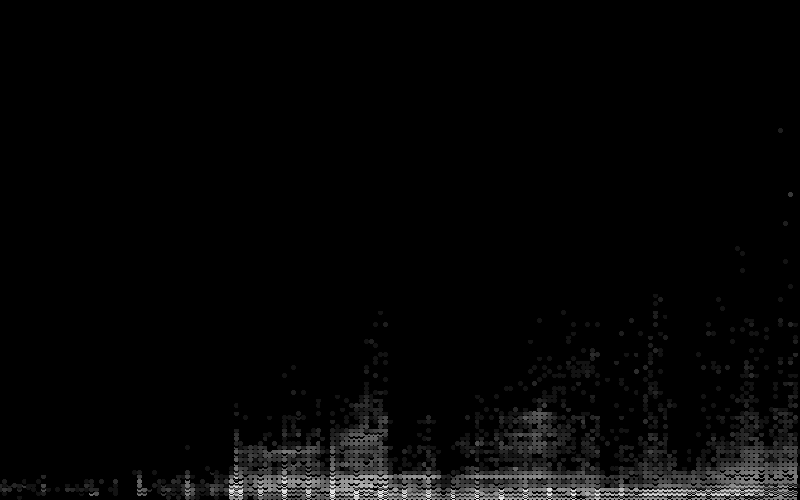

In [27]:
cvs = ds.Canvas(800, 500, x_range = (ny['YearBuilt'].min(), ny['YearBuilt'].max()), 
                                y_range = (ny['NumFloors'].min(), ny['NumFloors'].max()))
agg = cvs.points(ny, 'YearBuilt', 'NumFloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

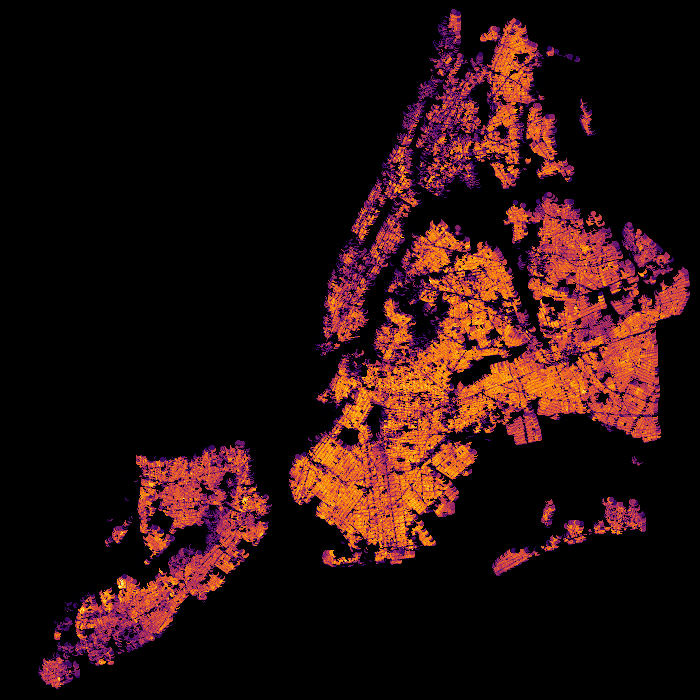

In [11]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

## Bivariate Choropleth Map

Below is a graphic of New York, with land values indicated by the color red, total value by the color blue; properties with low values for both are grey, properties high for both are a dark purplish grey color.

Palette source: http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/

C:\Users\asher\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



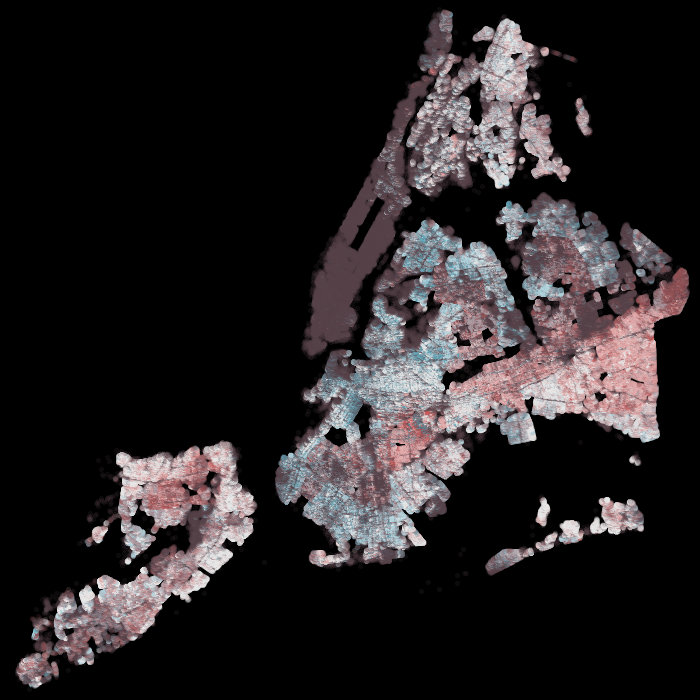

In [93]:
# Assign each row to one of nine groups, where the tens digit corresponds to property value, and the ones digit
# corresponds to land values. E.g. 12 corresponds to low property value, medium land value; 23 is medium property value
# high land value

ny["ChoroTot"] = 0
ny["ChoroTot"].loc[ny['AssessTot'] <= ny["AssessTot"].quantile(q=1/3)] = 10 # Low Property Value
ny["ChoroTot"].loc[ny['AssessTot'] > ny["AssessTot"].quantile(q=2/3)] = 30 # High Property Value
ny["ChoroTot"].loc[ny['ChoroTot'] == 0] = 20 # Medium Property Value

ny["ChoroLand"] = 0
ny["ChoroLand"].loc[ny['AssessLand'] <= ny["AssessLand"].quantile(q=1/3)] = 1 # Low Land Value
ny["ChoroLand"].loc[ny['AssessLand'] > ny["AssessLand"].quantile(q=2/3)] = 3 # High Land Value
ny["ChoroLand"].loc[ny['ChoroLand'] == 0] = 2 # Medium Land Value

ny["ChoroGroup"] = ny["ChoroTot"] + ny["ChoroLand"]
#ny.ChoroGroup = ny.ChoroGroup.astype(str)
ny.ChoroGroup = ny.ChoroGroup.astype('category')

color_key = {31:'#64acbe', 32:'#627f8c',  33:'#574249',
             21:'#b0d5df', 22:'#ad9ea5',  23:'#985356',
             11:'#e8e8e8', 12:'#e4acac',  13:'#c85a5a'}

# Map of land values, brighter is higher
NewYorkCity   = (( -74.27,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.count_cat('ChoroGroup'))
view = tf.shade(agg, color_key = color_key, how='eq_hist')
#view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')


<img src="Palette.jpg">

In [13]:
# Create Unique IDs for each lot
ny["UniqueID"] = ny['Borough'].map(str) + ny['Block'].map(str) + ny['Lot'].map(str)

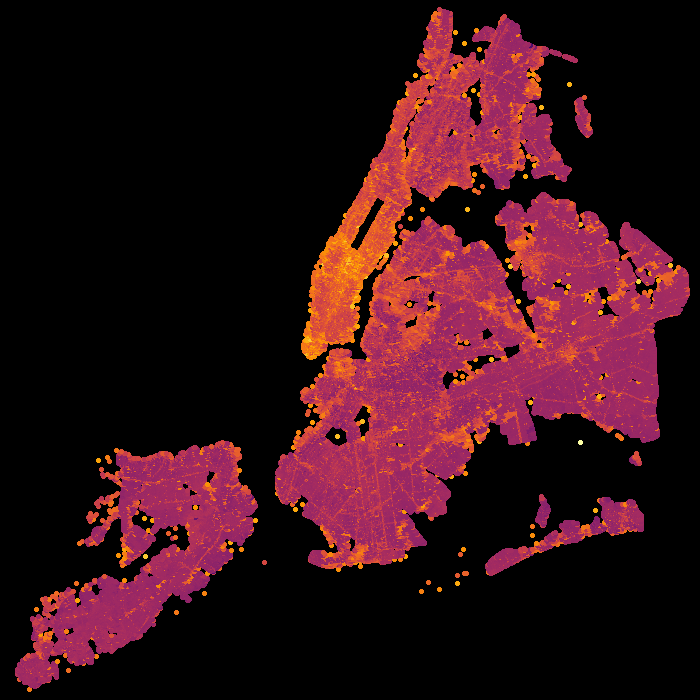

In [14]:
# Map of land values, brighter is higher
NewYorkCity   = (( -74.27,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.mean('AssessLand'))
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

### New York City Land Value Map
As we'd expect, the map above shows the highest land values in Manhattan. But this just shows the land value per plot, while plots vary in size. Let's normalize it for size, by dividing land value by the lot area, in square feet.

Some of the lot area values are zero, so we will temporarily remove those.

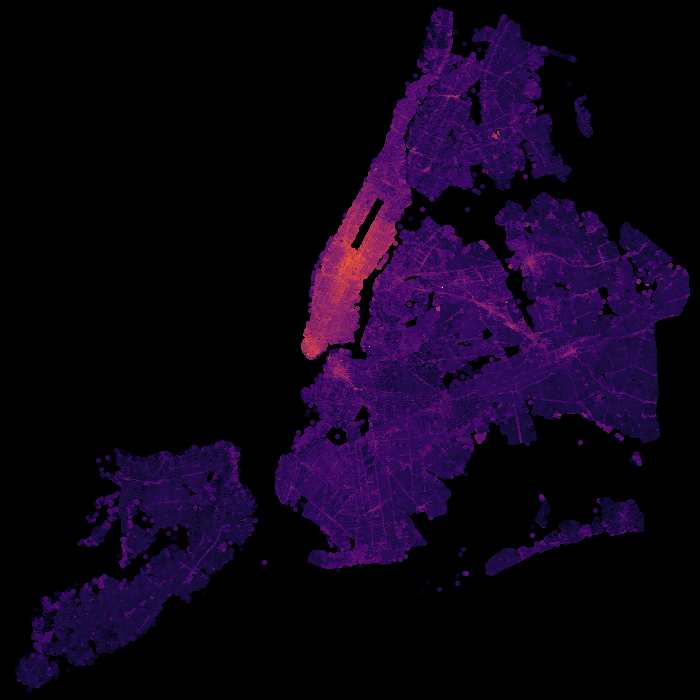

In [15]:
ny['LandSqFt'] = ny["AssessLand"] / ny["LotArea"]
ny1 = ny[ny["LotArea"] > 0]

# Map of land values per square foot, brighter is higher
NewYorkCity   = (( -74.27,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny1, 'lon', 'lat', ds.mean('LandSqFt'))
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

## Normalized NYC Land Value Map

Now, this map brings into sharp relief the land value variation throughout the city. 

Now, let's take a look at where property is underbuilt, overbuilt, or just right. An underbuilt property would be one that is empty, where lots of people live or work. However, this is imprecise - you may have a piece of land whose most profitable use is as a farm, where there are no buildings.

An overbuilt one would be, say a skyscraper in the middle of nowhere. The advantage of skyscrapers is that they spread the cost of land over more built space, but at the cost of higher unit costs per square foot of built space - you have to use stronger costly materials and devote more of the building envelope to structural support, leaving less leasable space.



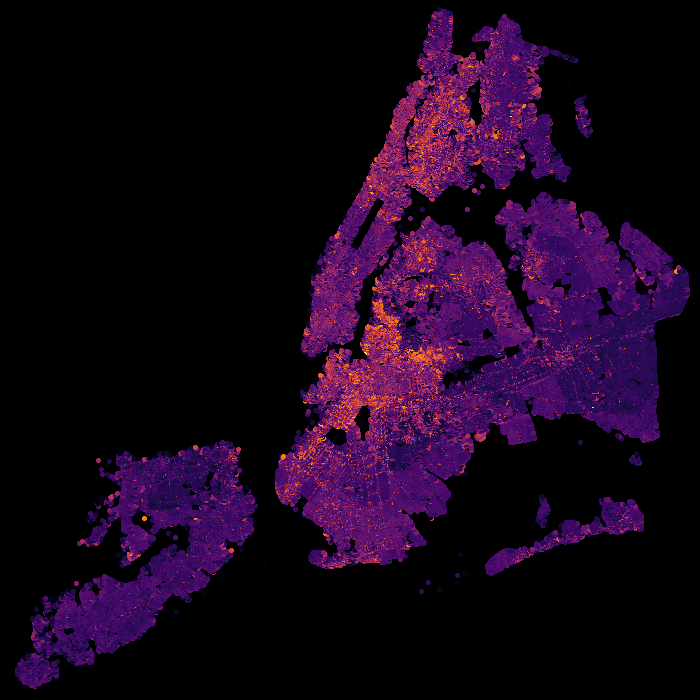

In [18]:
# Calculate Property to Land Value Ratio
ny['TotOverLand'] = ny['AssessTot'] / ny['AssessLand'] 

NewYorkCity   = (( -74.27,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat', ds.mean('TotOverLand'))
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

### NYC Property to Land Value Ratio Map

Many people believe that Manhattan is overbuilt, because there are so many tall buildings. Financially speaking, this is not accurate - land values are higher than elsewhere, but proportionally property values are not. The median ratio in Manhattan is 4.1, while in the rest of NYC, it's 3.0. Manhattan's ratio is nearly at the 75th percentile of the rest of the city - so while higher, it's not anomalously high compared to the rest of  the city.

We can see that parts of Brooklyn have even higher property to land value ratios, with a median of 5.3, across the two zip codes 11222, 11211. 

Still, there are some properties whose value is almost entirely land. The lot may be vacant, or the property is a tear-down and thus the building has negative value.

In [19]:
# Summary Statistics of Property / Land Value, Manhattan
mn = ny[ny["Borough"] == "MN"]
mn["TotOverLand"].describe()

count    40135.000000
mean         5.900311
std          8.425797
min          1.000000
25%          2.735882
50%          4.083358
75%          6.681619
max        734.289107
Name: TotOverLand, dtype: float64

In [20]:
# Summary Statistics of Property / Land Value, Not Manhattan
notMN = ny[ny["Borough"] != "MN"]
notMN["TotOverLand"].describe()

count    771644.000000
mean          4.888528
std           9.792594
min           1.000000
25%           2.378028
50%           3.004757
75%           3.931529
max        1270.840000
Name: TotOverLand, dtype: float64

In [21]:
# Summary Statistics of Property / Land Value, Northern Brooklyn zipcodes
northBrooklyn = ny['ZipCode'].isin([11222, 11211])

ny.ix[northBrooklyn, 'TotOverLand'].describe()

C:\Users\asher\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



count    10230.000000
mean        17.137340
std         26.739973
min          1.003125
25%          3.807329
50%          5.307521
75%          9.081929
max        200.918977
Name: TotOverLand, dtype: float64

In [22]:
# NYC Properties with lowest property to land value ratio
ny.sort_values(by = 'TotOverLand').loc[ :, ["Address", "Borough", "AssessLand", "AssessTot", "TotOverLand"]].head(20)

,Address,Borough,AssessLand,AssessTot,TotOverLand
354695,1020 DEAN AVENUE,BX,11400,11400,1.0
134604,25 EAST 19 STREET,BK,30526,30526,1.0
131194,1506 NEW YORK AVENUE,BK,14444,14444,1.0
46116,986 BROADWAY,BK,119250,119250,1.0
46115,984 BROADWAY,BK,104400,104400,1.0
14003,3 AVENUE,BK,137,137,1.0
298271,2264 MORRIS AVENUE,BX,514800,514800,1.0
131193,1502 NEW YORK AVENUE,BK,14450,14450,1.0
510979,20-12 125 STREET,QN,13800,13800,1.0
387123,989 3 AVENUE,MN,1575900,1575900,1.0


In [23]:
# Manhattan Properties with lowest property to land value ratio
ny[ny["Borough"] == "MN"].sort_values(by = 'TotOverLand').loc[ :, ["Address", "Borough", 
                                                                   "AssessLand", "AssessTot", "TotOverLand"]].head(20)

,Address,Borough,AssessLand,AssessTot,TotOverLand
387124,987 3 AVENUE,MN,605700,605700,1.000000
387125,985 3 AVENUE,MN,694350,694350,1.000000
401179,173 MORNINGSIDE AVENUE,MN,202050,202050,1.000000
387123,989 3 AVENUE,MN,1575900,1575900,1.000000
378873,154 EAST 23 STREET,MN,1161000,1161450,1.000388
395038,315 EAST 111 STREET,MN,155700,156150,1.002890
376551,245 WEST 34 STREET,MN,1462500,1467000,1.003077
379664,261 3 AVENUE,MN,789750,794250,1.005698
379637,228 EAST 20 STREET,MN,3274650,3297150,1.006871
386943,249 EAST 50 STREET,MN,1369350,1382850,1.009859
